In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

c:\Users\Chloe\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Exploration

In [2]:
ds = load_dataset("Nooha/cc_fraud_detection_dataset")
df = ds["train"].to_pandas() # convert to pandas dataframe

In [3]:
# Check data types and missing values
print("\nDataset information:")
print(df.info())

missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values found")

# Check overall statistics
print(df.describe())


Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646694 entries, 0 to 2646693
Data columns (total 20 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   city        object 
 6   state       object 
 7   zip         int64  
 8   city_pop    int64  
 9   job         object 
 10  dob         object 
 11  acct_num    int64  
 12  trans_num   object 
 13  trans_date  object 
 14  trans_time  object 
 15  unix_time   int64  
 16  category    object 
 17  amt         float64
 18  is_fraud    int64  
 19  merchant    object 
dtypes: float64(1), int64(6), object(13)
memory usage: 403.9+ MB
None

Missing Values:
No missing values found
             cc_num           zip      city_pop      acct_num     unix_time  \
count  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06  2.646694e+06   
mean   4.029946e+17  5.231005e+04  2.856760e+0

## Data Preprocessing

In [4]:
df1 = df.copy()
df1 = df1.drop(['first', 'last'], axis=1) # drop first and last name columns

In [5]:
# Convert date and time to appropriate data types
df1['trans_date'] = pd.to_datetime(df1['trans_date'])
df1['dob'] = pd.to_datetime(df1['dob'])
df1['trans_time'] = pd.to_datetime(df1['trans_time'], format='%H:%M:%S')

# Extract transaction time features
df1['hour'] = df1['trans_time'].dt.hour
df1['day_of_week'] = df1['trans_date'].dt.day_name()
df1['month'] = df1['trans_date'].dt.month

# Calculate age at the time of the transaction
df1['age'] = (df1['trans_date'] - df1['dob']).dt.days / 365.25
df1['age_group'] = pd.cut(df1['age'], bins=range(0, 101, 10), right=False, 
                             labels=[f"{i}-{i+10}" for i in range(0, 100, 10)]) 

# Merge city and state columns
df1['city_state'] = df1['city'] + ', ' + df1['state']

In [6]:
# df1.info()

Fraud Distribution:
is_fraud
0    2637272
1       9422
Name: count, dtype: int64
Fraud Rate: 0.0036 (0.36%)


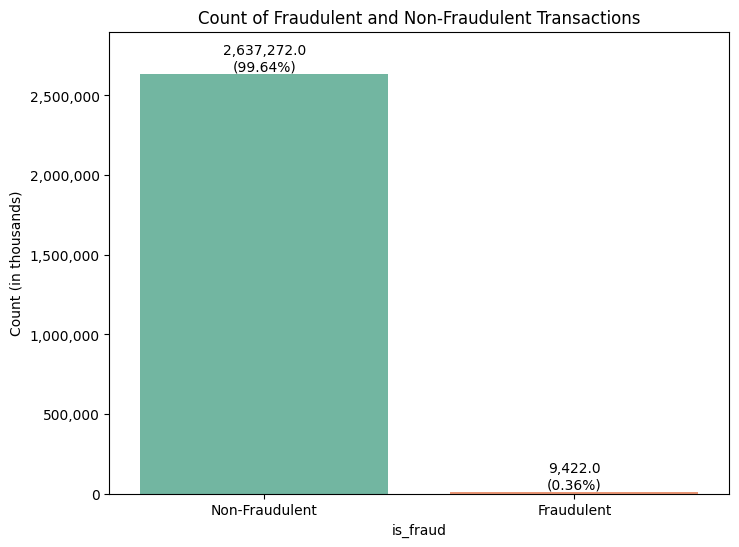

In [7]:
# Fraud distribution
print("Fraud Distribution:")
fraud_counts = df1['is_fraud'].value_counts()
print(fraud_counts)

# Fraud rate
fraud_rate = df1['is_fraud'].mean()
print(f"Fraud Rate: {fraud_rate:.4f} ({fraud_rate * 100:.2f}%)")

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='is_fraud', hue='is_fraud', palette='Set2', legend=False)

# Customize the plot
ax.set_ylabel('Count (in thousands)')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title('Count of Fraudulent and Non-Fraudulent Transactions')
ax.set_xticks([0, 1])  # Set x-ticks
ax.set_xticklabels(['Non-Fraudulent', 'Fraudulent'])  # Label x-axis

# Extend y-axis limits slightly for readability
plt.ylim(0, max(fraud_counts) * 1.1)
# Add count and percentage on the bars
total_count = len(df)
for p in ax.patches:
    height = p.get_height()
    percentage = (height / total_count) * 100
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position (center of the bar)
        height + 1000,  # Y position (slightly above the bar)
        f'{height:,}\n({percentage:.2f}%)',  # Text (count and percentage)
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=10
    )

plt.show()

In [25]:
# Check unique values in categorical columns
categorical = []

for f in df1.columns:
    feature = df1[f]

    print(f'{f} unique values: {feature.nunique()}')
    if feature.dtype == float or feature.dtype == '<M8[ns]':
        print(' Not categorical')
        continue
    if feature.nunique() < len(df1)/2:
        categorical.append(f)
        if feature.nunique() < 10:
            print(f'    Unique values: {feature.unique()}')
        continue
    print(' Not categorical')

ssn unique values: 997
cc_num unique values: 997
gender unique values: 2
    Unique values: ['F' 'M']
city unique values: 741
state unique values: 51
zip unique values: 942
city_pop unique values: 787
job unique values: 420
dob unique values: 978
 Not categorical
acct_num unique values: 997
trans_num unique values: 2646694
 Not categorical
trans_date unique values: 1095
 Not categorical
trans_time unique values: 86400
 Not categorical
unix_time unique values: 2573660
 Not categorical
category unique values: 14
amt unique values: 70272
 Not categorical
is_fraud unique values: 2
    Unique values: [1 0]
merchant unique values: 648
hour unique values: 24
day_of_week unique values: 7
    Unique values: ['Saturday' 'Sunday' 'Thursday' 'Wednesday' 'Friday' 'Monday' 'Tuesday']
month unique values: 12
age unique values: 30337
 Not categorical
age_group unique values: 9
    Unique values: ['30-40', '20-30', '40-50', '50-60', '60-70', '70-80', '90-100', '80-90', '10-20']
Categories (10, object):

In [9]:
# Summary statistics for fraudulent transactions
fraud_summary = df1[df1['is_fraud'] == 1].describe()
# print(fraud_summary)

In [10]:
# helper functions
def fraud_filter(cols):
    return df1[df1['is_fraud'] == 1].groupby(cols).size().reset_index(name='fraud_count')

def fraud_summary(df, col):
    print(f'Average fraud per {col}: {np.mean(df['fraud_count'])}')
    print(f'Median fraud per {col}: {np.median(df['fraud_count'])}')
    print(f'Standard deviation fraud per {col}: {np.std(df['fraud_count'])}')


## Fraudulent transactions by hour

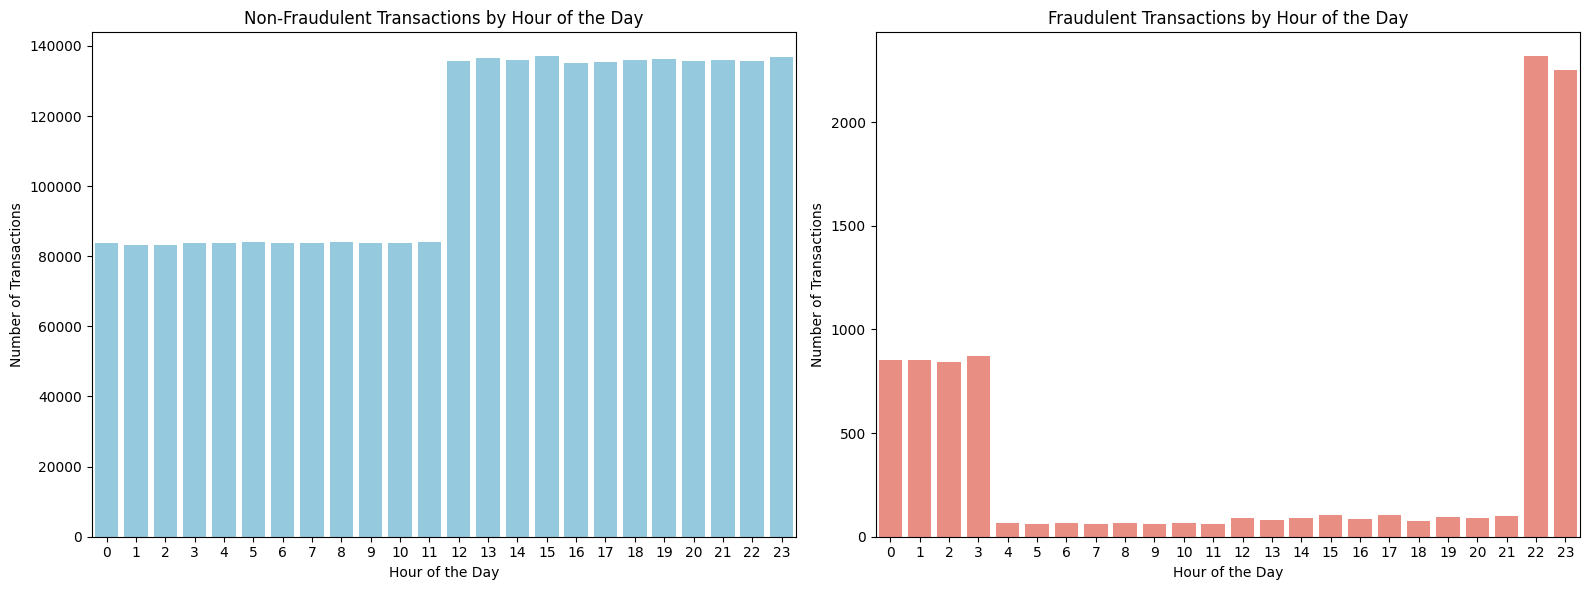

In [11]:
hour_fraud = df1.groupby(['hour', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for hour analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Non-Fraudulent Transactions by hour
sns.barplot(x=hour_fraud.index, y=hour_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Hour of the Day')
axes[0].set_xlabel('Hour of the Day')
axes[0].set_ylabel('Number of Transactions')

# Plot Fraudulent Transactions by hour
sns.barplot(x=hour_fraud.index, y=hour_fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Hour of the Day')
axes[1].set_xlabel('Hour of the Day')
axes[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

In [37]:
# Group by unix_time and count transactions
time_grouped = df1.groupby('unix_time').agg(
    num_transactions=('trans_num', 'size'),
    num_unique_cards=('cc_num', 'nunique'),
    num_unique_merchants=('merchant', 'nunique'),
    num_fraud=('is_fraud', 'sum'),
).reset_index()

# Filter for times with multiple transactions
suspicious_times = time_grouped[time_grouped['num_transactions'] > 1].sort_values(by='num_transactions', ascending=False)

# Display the top 10 suspicious times
print("Top 10 Suspicious unix_time with multiple transactions:")
print(suspicious_times.head(10))

# results show that despite sharing unix_time, most of these transactions seem to be all unique and independent,
# hence unlikely to be coordinated fraud. Could be due to peak shopping times or other reasons.  

Top 10 Suspicious unix_time with multiple transactions:
          unix_time  num_transactions  num_unique_cards  num_unique_merchants  \
829445   1640427909                 5                 5                     5   
2299353  1695553714                 5                 5                     5   
2556003  1703772009                 5                 5                     5   
376979   1625265945                 4                 4                     4   
471629   1628374273                 4                 4                     4   
178987   1617998927                 4                 4                     4   
1215969  1656161807                 4                 4                     4   
558446   1631405689                 4                 4                     4   
343805   1624137368                 4                 4                     4   
491215   1628990684                 4                 4                     4   

         num_fraud  
829445           0  
2299353   

## Fraudulent transactions by date

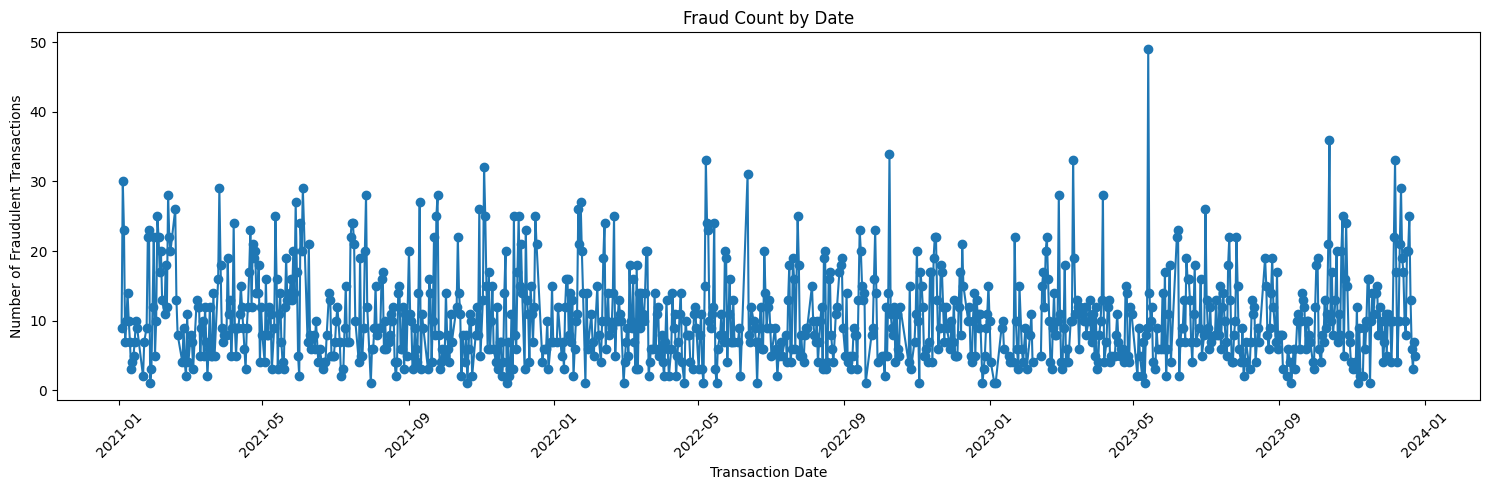

Dates with highest fraud:
    trans_date  fraud_count
713 2023-05-14           49
837 2023-10-13           36
540 2022-10-09           34
415 2022-05-08           33
659 2023-03-12           33
889 2023-12-07           33
255 2021-11-03           32
442 2022-06-12           31
1   2021-01-04           30
65  2021-03-26           29


In [12]:
fraud_count_by_date = fraud_filter('trans_date')

plt.figure(figsize=(15, 5))
plt.plot(fraud_count_by_date['trans_date'], fraud_count_by_date['fraud_count'], marker='o', linestyle='-')
plt.title('Fraud Count by Date')
plt.xlabel('Transaction Date')
plt.ylabel('Number of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show dates with highest fraud
print("Dates with highest fraud:")
highest_fraud_dates = fraud_count_by_date.sort_values(by='fraud_count', ascending=False)
print(highest_fraud_dates.head(10))

In [27]:
unix_count = df1.groupby('unix_time')['unix_time'].count().reset_index(name='count').sort_values('count', ascending=False)
unix_count = unix_count[unix_count['count'] > 1]['unix_time']

duplicated_unix_time = df1[df1['unix_time'].isin(unix_count)].sort_values('unix_time')
duplicated_unix_time

,ssn,cc_num,gender,city,state,zip,city_pop,job,dob,acct_num,...,category,amt,is_fraud,merchant,hour,day_of_week,month,age,age_group,city_state
1058234,804-92-8268,503871487271,F,Avon,CT,6001,18385,Music therapist,1988-06-17,308233949370,...,gas_transport,173.85,0,fraud_Cummings LLC,0,Friday,1,32.542094,30-40,"Avon, CT"
2576115,024-73-0528,4599996636186379,F,Dallas,TX,75252,1263321,Embryologist,2000-12-21,73869137112,...,gas_transport,69.51,0,fraud_Bins-Rice,0,Friday,1,20.030116,20-30,"Dallas, TX"
984222,158-90-8788,5573585730652407,M,Gibsonia,PA,15044,27049,Designer,2000-12-06,580116407639,...,gas_transport,46.29,0,fraud_Raynor,0,Friday,1,20.071184,20-30,"Gibsonia, PA"
389317,568-92-0313,213164931214636,F,Wickes,AR,71973,1424,Engineer,1966-05-25,118531854265,...,gas_transport,1.36,0,fraud_Christiansen,0,Friday,1,54.606434,50-60,"Wickes, AR"
86591,813-38-6608,30391900889913,F,Marietta,GA,30062,302309,Engineer,1985-06-17,502226927571,...,gas_transport,84.93,0,fraud_Cummings LLC,0,Friday,1,35.542779,30-40,"Marietta, GA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268502,310-24-3661,373711222990773,M,Fort Worth,TX,76103,813980,Health promotion specialist,1974-06-29,611759212133,...,travel,5.25,0,fraud_Hodkiewicz,23,Sunday,12,49.505818,40-50,"Fort Worth, TX"
414092,069-45-2671,4029295014372,F,Massapequa,NY,11758,53804,Therapist,2006-08-29,100931152672,...,travel,2.31,0,fraud_Fritsch LLC,23,Sunday,12,17.338809,10-20,"Massapequa, NY"
684163,869-59-1502,4900532931839331,M,Dallas,TX,75252,1263321,Agricultural engineer,1988-02-27,13450992449,...,travel,3.05,0,fraud_Kovacek Ltd,23,Sunday,12,35.841205,30-40,"Dallas, TX"
1382692,206-42-7252,4233222801944258926,M,Cleveland,OH,44126,769341,Artist,2000-04-12,429068169930,...,travel,4.02,0,fraud_Corwin-Romaguera,23,Sunday,12,23.718001,20-30,"Cleveland, OH"


In [28]:
fraud_duplicates_m = duplicated_unix_time[duplicated_unix_time['is_fraud'] == 1].groupby(['merchant'])['merchant'].count().reset_index(name='count')
fraud_duplicates_m = fraud_duplicates_m[fraud_duplicates_m['count'] > 1].sort_values('count', ascending=False)
fraud_duplicates_m.head(10)

,merchant,count
150,fraud_Reichert,8
156,fraud_Romaguera,5
140,fraud_O'Keefe-Hudson,4
141,fraud_Pacocha-O'Reilly,4
21,fraud_Boyer PLC,4
45,fraud_Fisher-Schowalter,4
31,fraud_Cormier LLC,3
51,fraud_Gerlach Inc,3
89,fraud_Jaskolski-Vandervort,3
85,fraud_Huel-Langworth,3


## Fraudulent transactions by location

C:\Users\Chloe\AppData\Local\Temp\ipykernel_39372\3024622567.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary['state'], fontsize=8)


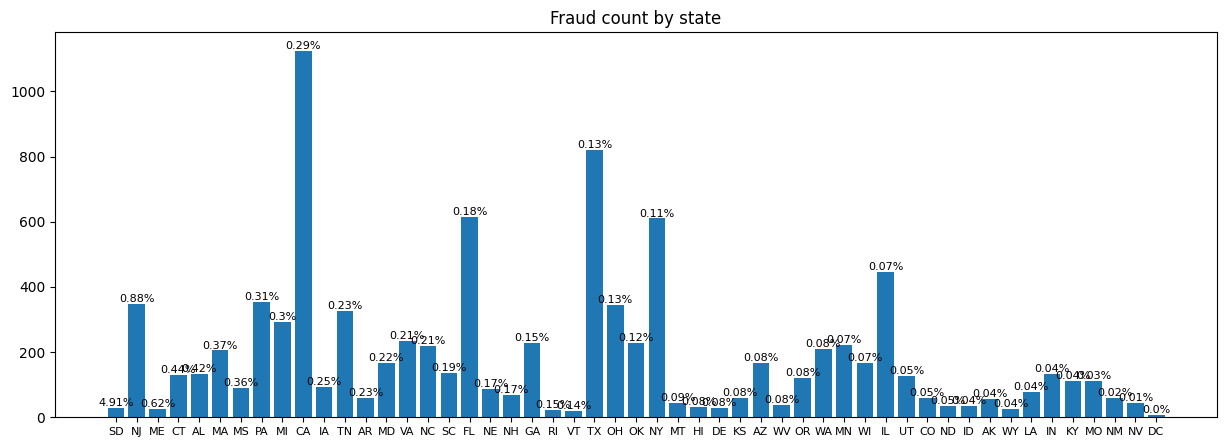

In [13]:
fraud_count_by_state = fraud_filter('state')
pop = df1.groupby('state')['city_pop'].mean().reset_index(name='mean_pop')

summary = fraud_count_by_state.merge(pop, on='state')
summary['percentage'] = round(summary['fraud_count']/summary['mean_pop']*100, 2)
summary = summary.sort_values(by='percentage', ascending=False)

fig, ax = plt.subplots(figsize=(15,5))

ax.bar(summary['state'], summary['fraud_count'])
ax.set_title('Fraud count by state')
ax.set_xticklabels(summary['state'], fontsize=8)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.annotate(f'{summary["percentage"].iloc[i]}%', 
                (p.get_x() + p.get_width() / 2, height), 
                ha='center', va='bottom', fontsize=8)

plt.show()

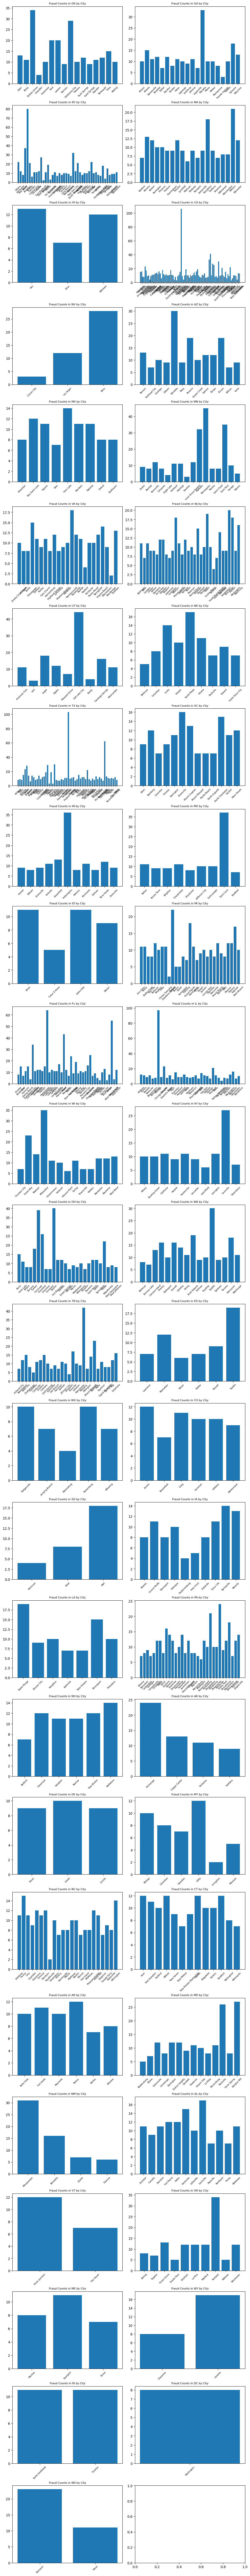

In [14]:
fraud_count_by_city = fraud_filter(['state', 'city'])

states = list(df1['state'].unique())
n = len(states)

fig, ax = plt.subplots(n//2+1, 2, figsize=(10, 4*(n//2+1)), constrained_layout=True)

ax = ax.flatten()
for i, state in enumerate(states):
    temp = fraud_count_by_city[fraud_count_by_city['state'] == state]

    ax[i].bar(temp['city'], temp['fraud_count'])
    ax[i].set_title(f'Fraud Counts in {state} by City', fontsize=8)
    ax[i].tick_params(axis='x', rotation=45, labelsize=6)

plt.show()

In [15]:
# City-level analysis across states
fraud_count_by_city = fraud_filter(['state', 'city'])
fraud_summary(fraud_count_by_city, 'city')

# Show highest fraud cities
print("\nCities with highest fraud counts:")
highest_fraud_loc = fraud_count_by_city[fraud_count_by_city['fraud_count'] > 12].sort_values(by='fraud_count', ascending=False)
print(highest_fraud_loc.head(10))

Average fraud per city: 12.094993581514762
Median fraud per city: 10.0
Standard deviation fraud per city: 9.152044075009778

Cities with highest fraud counts:
    state             city  fraud_count
70     CA      Los Angeles          106
680    TX          Houston          103
229    IL          Chicago           97
481    NY         Brooklyn           80
156    FL     Jacksonville           64
701    TX      San Antonio           62
183    FL  West Palm Beach           55
368    MN      Minneapolis           45
714    UT   Salt Lake City           44
163    FL            Miami           43


## Fraudulent transactions by category

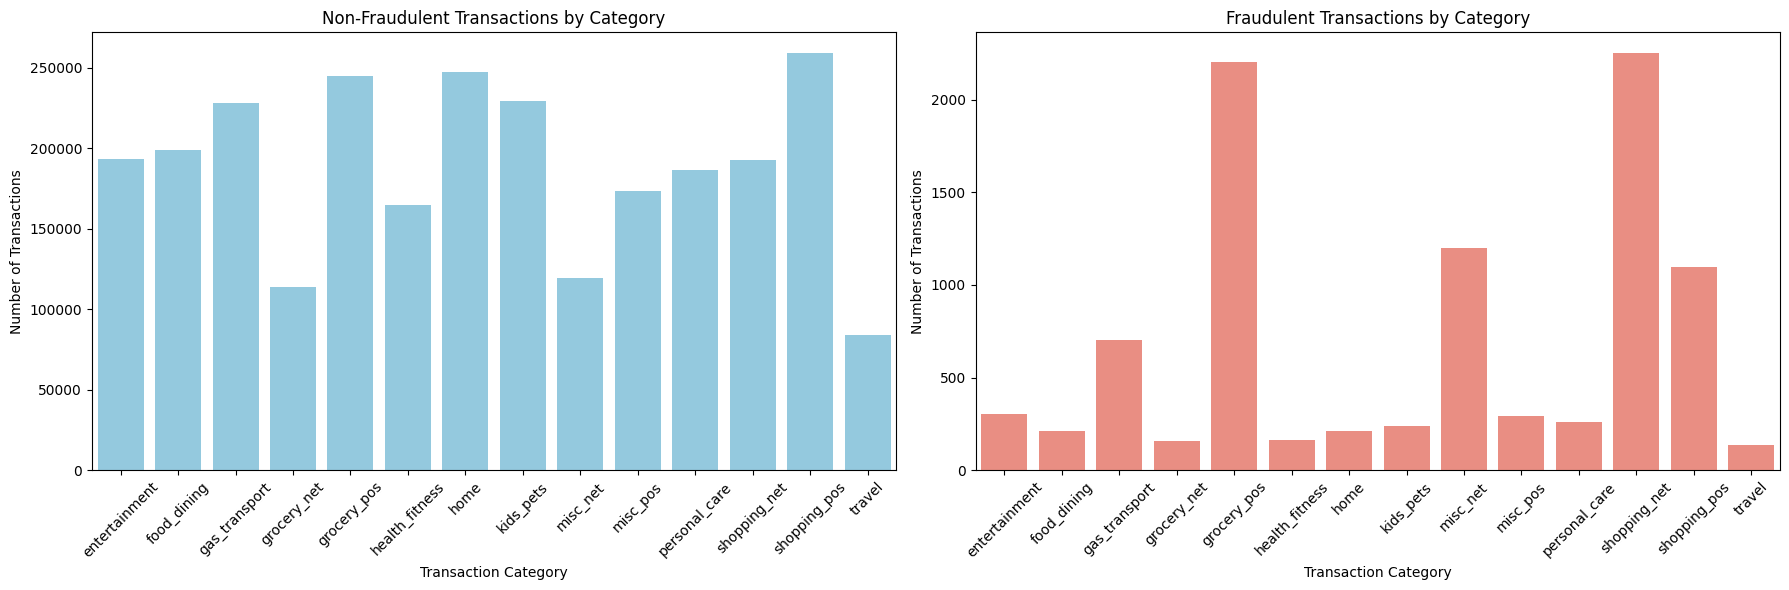

In [16]:
category_fraud = df1.groupby(['category', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for category analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot Non-Fraudulent Transactions by category
sns.barplot(x=category_fraud.index, y=category_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Category')
axes[0].set_xlabel('Transaction Category')
axes[0].set_ylabel('Number of Transactions')
axes[0].tick_params(axis='x', rotation=45)

# Plot Fraudulent Transactions by category
sns.barplot(x=category_fraud.index, y=category_fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Category')
axes[1].set_xlabel('Transaction Category')
axes[1].set_ylabel('Number of Transactions')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## Fraudulent transactions by age group

C:\Users\Chloe\AppData\Local\Temp\ipykernel_39372\2943096036.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_fraud = df1.groupby(['age_group', 'is_fraud']).size().unstack(fill_value=0)


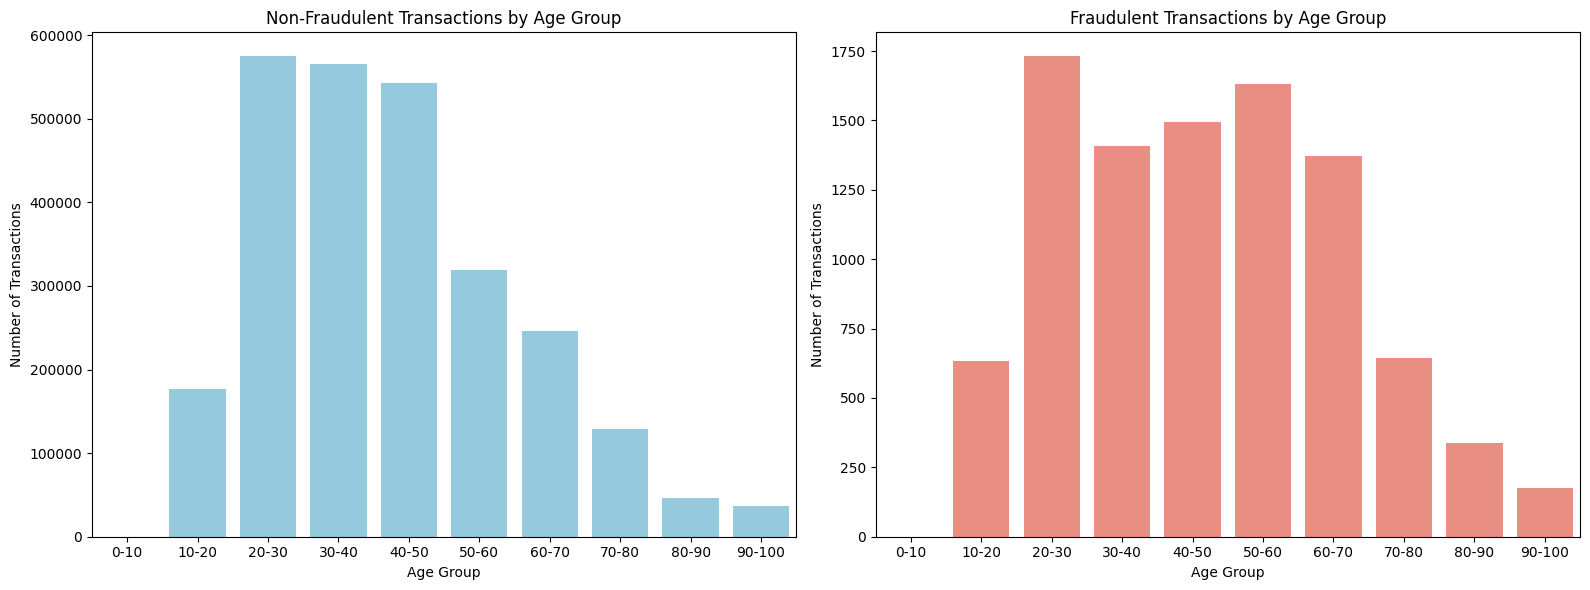

In [17]:
# Age analysis
age_fraud = df1.groupby(['age_group', 'is_fraud']).size().unstack(fill_value=0)

# Create subplots for age analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Non-Fraudulent Transactions by age
sns.barplot(x=age_fraud.index, y=age_fraud[0], color='skyblue', ax=axes[0])
axes[0].set_title('Non-Fraudulent Transactions by Age Group')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Number of Transactions')

# Plot Fraudulent Transactions by age
sns.barplot(x=age_fraud.index, y=age_fraud[1], color='salmon', ax=axes[1])
axes[1].set_title('Fraudulent Transactions by Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

## Fraudulent transactions by merchant

Merchants with highest fraud counts:
                  merchant  fraud_count
472         fraud_Reichert          152
416         fraud_Mosciski           94
28          fraud_Baumbach           93
561          fraud_Streich           63
492        fraud_Romaguera           60
254             fraud_Huel           57
197        fraud_Greenholt           56
25   fraud_Bashirian Group           55
18      fraud_Bailey-Morar           55
316          fraud_Kovacek           55
Average fraud per merchant: 14.698907956318253
Median fraud per merchant: 7.0
Standard deviation fraud per merchant: 16.620424686155232


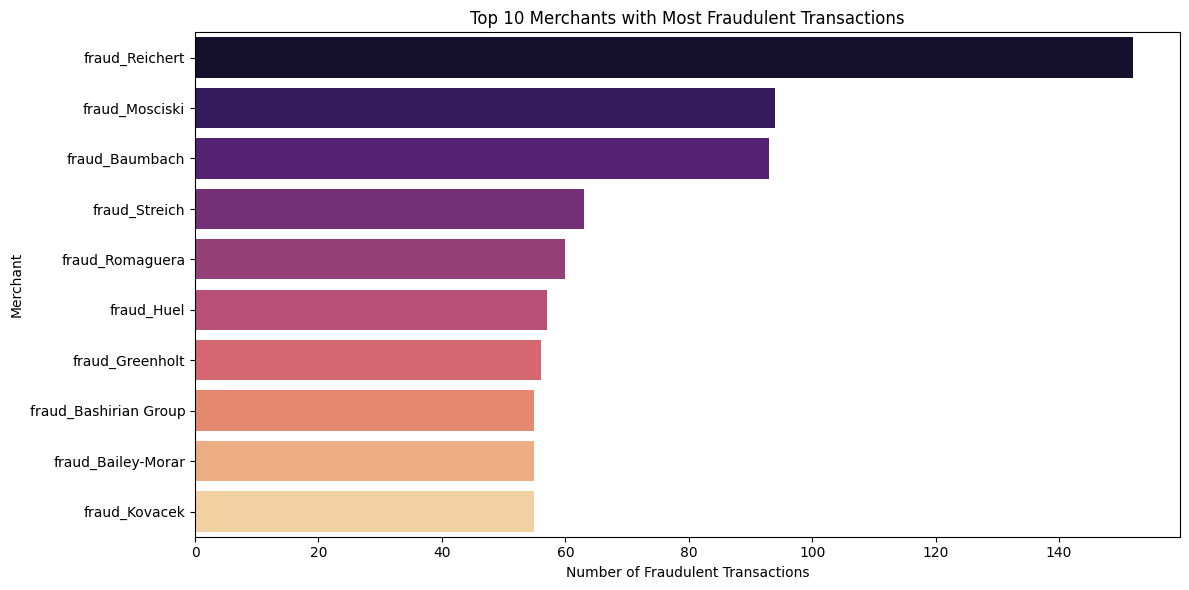


Analysis of top fraud merchants:
Merchant: fraud_Reichert
    Number of fraud transactions: 152
    Number of unique locations: 727
    Number of total customers: 11826
    Number of unique customers: 904
    Number of unique customers in fraud transactions: 140
    Average transaction amount: $75.36
    Most common transaction category: shopping_net
Merchant: fraud_Mosciski
    Number of fraud transactions: 94
    Number of unique locations: 726
    Number of total customers: 8780
    Number of unique customers: 902
    Number of unique customers in fraud transactions: 92
    Average transaction amount: $78.40
    Most common transaction category: grocery_pos
Merchant: fraud_Baumbach
    Number of fraud transactions: 93
    Number of unique locations: 724
    Number of total customers: 14092
    Number of unique customers: 902
    Number of unique customers in fraud transactions: 92
    Average transaction amount: $69.34
    Most common transaction category: shopping_pos


In [18]:
# Top merchants with fraudulent transactions
fraud_count_by_merchant = fraud_filter('merchant').sort_values(by='fraud_count', ascending=False)
print("Merchants with highest fraud counts:")
print(fraud_count_by_merchant.head(10))

# Calculate fraud summary stats for merchants
fraud_summary(fraud_count_by_merchant, 'merchant')

# Visualize top 10 merchants with most fraudulent transactions
top_fraud_merchants = fraud_count_by_merchant.nlargest(10, 'fraud_count')

plt.figure(figsize=(12, 6))
sns.barplot(x='fraud_count', y='merchant', data=top_fraud_merchants, hue='merchant',palette='magma', legend=False)
plt.title('Top 10 Merchants with Most Fraudulent Transactions')
plt.xlabel('Number of Fraudulent Transactions')
plt.ylabel('Merchant')
plt.tight_layout()
plt.show()

# Detailed analysis of top fraud merchants
print("\nAnalysis of top fraud merchants:")
fraud_merchants = list(fraud_count_by_merchant['merchant'].head(3))
for m in fraud_merchants:
    temp = df1[df1['merchant'] == m]
    print(f'Merchant: {m}')
    print(f'    Number of fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].count()}')
    print(f'    Number of unique locations: {temp["city_state"].nunique()}')
    print(f'    Number of total customers: {temp["ssn"].count()}')
    print(f'    Number of unique customers: {temp["ssn"].nunique()}')
    print(f'    Number of unique customers in fraud transactions: {temp[temp["is_fraud"] == 1]["ssn"].nunique()}')
    avg_transaction_amount = temp['amt'].mean()
    print(f'    Average transaction amount: ${avg_transaction_amount:.2f}')
    most_common_category = temp['category'].mode()[0]  # take the first value
    print(f'    Most common transaction category: {most_common_category}')

In [19]:
least_fraud_m = fraud_count_by_merchant.sort_values(by='fraud_count', ascending=True)
least_fraud_m.head(10)

,merchant,fraud_count
504,fraud_Runte,1
630,fraud_Wuckert-Walter,1
473,fraud_Reichert-Weissnat,1
540,fraud_Skiles-Ankunding,1
554,fraud_Stark-Koss,1
558,fraud_Stokes,1
371,fraud_Little-Gleichner,1
454,fraud_Pouros,1
33,fraud_Bednar Inc,1
508,fraud_Satterfield-Lowe,1


In [20]:
least_fraud_filter = least_fraud_m[least_fraud_m['fraud_count'] == 1]['merchant']

fraud_count_mc = fraud_filter(['merchant', 'ssn'])
fraud_count_mc = fraud_count_mc[fraud_count_mc['merchant'].isin(least_fraud_filter)]
fraud_count_mc.head()

,merchant,ssn,fraud_count
253,fraud_Bahringer-Streich,504-14-2358,1
655,fraud_Bednar Inc,649-60-8105,1
813,fraud_Bins-Howell,437-44-6587,1
1034,fraud_Boyer-Haley,096-65-8934,1
1670,fraud_Deckow-Dare,589-05-8010,1


In [21]:
fraud_count_mc.groupby('ssn')['ssn'].count() 

ssn
059-31-8309    1
069-45-2671    1
096-65-8934    1
136-67-4961    1
162-08-8321    1
193-01-5279    1
206-42-7252    1
242-80-7389    1
297-22-0579    1
437-44-6587    1
452-57-9812    1
504-14-2358    1
546-98-9371    1
552-20-7135    1
581-88-4763    1
589-05-8010    1
601-89-5938    1
603-45-6914    1
627-46-9417    1
649-60-8105    1
755-11-1150    1
766-62-3506    1
808-05-0763    1
832-27-5040    1
855-20-0599    1
860-08-4836    1
877-44-8505    1
Name: ssn, dtype: int64

In [22]:
fraud_count_by_consumers = fraud_filter('ssn').sort_values(by='fraud_count', ascending=False)
fraud_count_by_consumers.head(10)

,ssn,fraud_count
719,648-07-3243,19
744,672-90-6422,18
454,428-32-3432,17
452,422-55-9671,16
485,461-60-7650,16
42,038-71-4270,16
341,311-93-4315,16
268,236-75-8053,16
846,766-62-3506,16
581,535-66-3820,16


In [23]:
least_fraud_c = fraud_count_by_consumers.sort_values(by='fraud_count', ascending=True)
least_fraud_c.head(10)

,ssn,fraud_count
654,590-86-8736,2
638,581-08-0162,2
637,580-38-0878,2
215,182-22-0390,2
548,505-02-6947,2
567,525-56-7036,2
490,465-98-6615,2
151,125-63-8352,2
553,507-88-8724,2
703,630-56-4499,3
